# LLM Strategy Notebook

Asset that we will study: **TSLA**

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import warnings


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
warnings.filterwarnings('ignore')

## 1- Dataset Preparation

### 1.1- Data Loading

In [4]:
# load json file that is a list of dicts
tsla_comment_path = "Data/processed/tesla_comments.json"
with open(tsla_comment_path) as f:
    tsla_comments = json.load(f)

# convert list of dicts to pandas dataframe
tsla_comments_df = pd.DataFrame(tsla_comments)
del tsla_comments

# convert unix timestamp to datetime
tsla_comments_df["date"] = pd.to_datetime(tsla_comments_df["date"], unit='s').dt.date

### 1.2- Data Cleaning/Preprocessing

In [5]:
# take all comments from the year 2021
tsla_comments_pers_df = tsla_comments_df[(tsla_comments_df["date"] >= pd.Timestamp(2021, 1, 4).date()) & (tsla_comments_df["date"] <= pd.Timestamp(2021, 12, 31).date())]

# creating a week column for universal week number
tsla_comments_pers_df["week"] = pd.to_datetime(tsla_comments_pers_df["date"]).dt.isocalendar().week

# grouping comments by week
tsla_comments_pers_df = tsla_comments_pers_df.groupby("week")["text"].apply(list).reset_index()

### 1.3- Data Analysis/Visualization

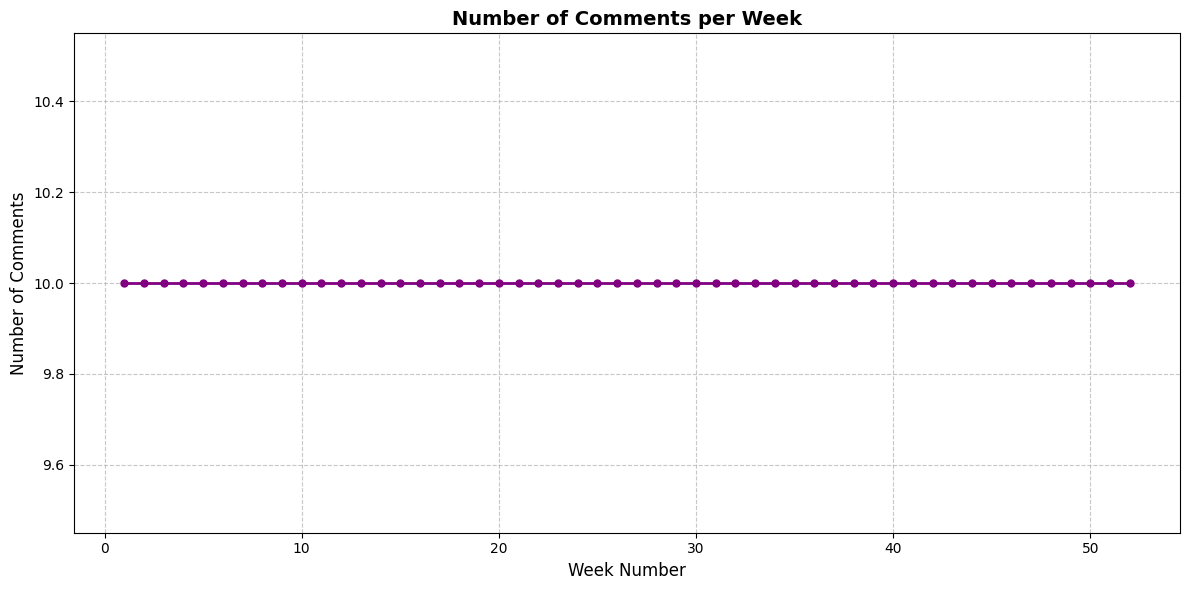

In [12]:
# plot the number of comments per week using matplotlib

plt.figure(figsize=(12, 6))
plt.plot(tsla_comments_pers_df["week"], tsla_comments_pers_df["text"].apply(len), color='purple', linewidth=2, marker='o', linestyle='-', markersize=5)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.title("Number of Comments per Week", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
# get the median length of comments per week
median = tsla_comments_pers_df["text"].apply(lambda x: sum([len(i.split(" ")) for i in x])/len(x)).median()
# get the standard deviation of the length of comments per week
std = tsla_comments_pers_df["text"].apply(lambda x: sum([len(i.split(" ")) for i in x])/len(x)).std()
# get the maximum length of comments per week and its index
max_len = tsla_comments_pers_df["text"].apply(lambda x: sum([len(i.split(" ")) for i in x])/len(x)).max()
max_len_index = tsla_comments_pers_df["text"].apply(lambda x: sum([len(i.split(" ")) for i in x])/len(x)).idxmax() + 1
# get the minimum length of comments per week and its index
min_len = tsla_comments_pers_df["text"].apply(lambda x: sum([len(i.split(" ")) for i in x])/len(x)).min()
min_len_index = tsla_comments_pers_df["text"].apply(lambda x: sum([len(i.split(" ")) for i in x])/len(x)).idxmin() + 1

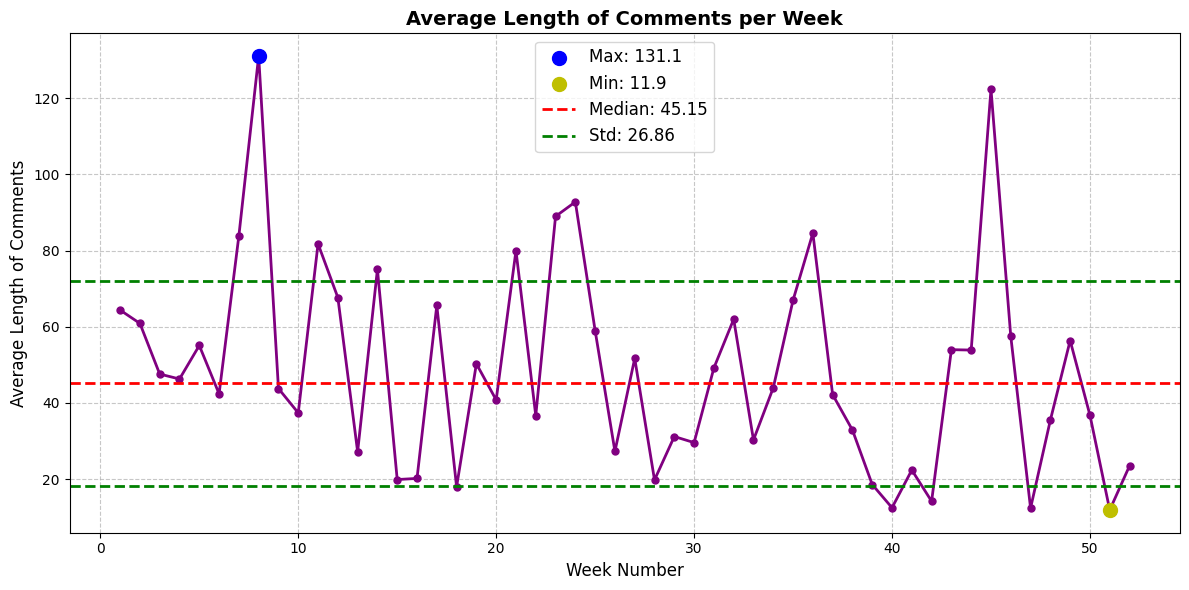

In [14]:
# plot the average length of comments per week
plt.figure(figsize=(12, 6))
plt.scatter(max_len_index, max_len, color='b', s=100, zorder=5, label=f"Max: {round(max_len, 2)}")
plt.scatter(min_len_index, min_len, color='y', s=100, zorder=5, label=f"Min: {round(min_len, 2)}")
plt.plot(tsla_comments_pers_df["week"], tsla_comments_pers_df["text"].apply(lambda x: sum([len(i.split(" ")) for i in x])/len(x)), color='purple', linewidth=2, marker='o', linestyle='-', markersize=5)
# plt.plot(sample_data["week"], sample_data["text_length"], color='purple', linewidth=2, marker='o', linestyle='-', markersize=5)
plt.axhline(median, color='r', linestyle='--', linewidth=2, label=f"Median: {round(median, 2)}")
plt.axhline(median + std, color='g', linestyle='--', linewidth=2, label=f"Std: {round(std, 2)}")
plt.axhline(median - std, color='g', linestyle='--', linewidth=2)

plt.legend(fontsize='large')
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Average Length of Comments", fontsize=12)
plt.title("Average Length of Comments per Week", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
def create_lda_model(documents, n_topics=5, max_df=0.95, min_df=2, random_state=42):
    """
    Creates and fits an LDA model on the provided documents.

    Parameters:
    - documents (list of str): The input documents.
    - n_topics (int): The number of topics to extract.
    - max_df (float): Ignore terms that have a document frequency higher than this threshold.
    - min_df (int): Ignore terms that have a document frequency lower than this threshold.
    - random_state (int): The seed used by the random number generator.

    Returns:
    - lda_model (LatentDirichletAllocation): The fitted LDA model.
    - feature_names (list of str): The feature names (vocabulary) used in the model.
    """

    # Create a document-term matrix
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
    dtm = vectorizer.fit_transform(documents)

    # Fit the LDA model
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=random_state)
    lda_model.fit(dtm)

    # Get the feature names (vocabulary)
    feature_names = vectorizer.get_feature_names_out()

    return lda_model, feature_names


def sample_texts_per_topic(lda_model, documents, n_samples=2, random_state=42):
    """
    Samples texts per topic from the provided documents based on the given LDA model.

    Parameters:
    - lda_model (LatentDirichletAllocation): The fitted LDA model.
    - documents (list of str): The input documents.
    - n_samples (int): The number of texts to sample per topic.
    - random_state (int): The seed used by the random number generator.

    Returns:
    - sampled_texts (dict): A dictionary where keys are topic indices and values are lists of sampled texts.
    """

    np.random.seed(random_state)
    # Create a document-term matrix
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(documents)

    # Get the topic distribution for each document
    topic_distributions = lda_model.transform(dtm)

    # Dictionary to store sampled texts for each topic
    sampled_texts = {i: [] for i in range(lda_model.n_components)}

    # Sample texts for each topic
    for topic_idx in range(lda_model.n_components):
        topic_docs_indices = np.argsort(topic_distributions[:, topic_idx])[::-1]
        sampled_indices = np.random.choice(topic_docs_indices[:50], n_samples, replace=False)
        sampled_texts[topic_idx] = [documents[i] for i in sampled_indices]

    sampled_texts = list(sampled_texts.values())
    sampled_texts = [item for sublist in sampled_texts for item in sublist]


    return sampled_texts


In [10]:
tsla_comments_pers_df['text'] = tsla_comments_pers_df['text'].apply(lambda l: sample_texts_per_topic(create_lda_model(l)[0], l, n_samples=2))

In [58]:
print("\n".join(tsla_comments_pers_df.iloc[0]['text']))

TSLA Curiosity I just saw this news report and always thought that Telsa "auto-pilot" helps to prevent this type of accident - yes, she fell asleep but why did it not engage or does auto-pilot need to be ON? Are they (TSLA) required to report this typeccident to NTSB [
Tesla’s 2020 deliveries beat WallStreet estimates as it delivered 499,550 vehicles last year 
$tsla gains, Dr PP was right 🚀🚀 
TSLA and NIO to the moon boys 🚀🚀 
Stock Market News for Today | TSLA vs FB | LMND SPIKES | APPLE CAR &amp; other stock market news [01-08] **Stocks finish at all-time highs as Tesla passes Facebook in market value. Stock Market News for Today | TSLA vs FB | LMND SPIKES | APPLE CAR &amp; other stock market news [01-08] **Stocks finish at all-time highs as Tesla passes Facebook in market value. So, let’ take a look at the [HEAT MAP]( from yesterday, as big tech companies flourished with the likes of Apple, Google, Microsoft, Facebook, Nvidia, Tesla and many more posting gains at least 2%, while mos

### 1.4- Stock Price Data

In [50]:
tsla_price_df = pd.read_csv("Data/prices/TSLA.csv")

In [51]:
# Compute the 7 day moving average of the closing price
tsla_price_df['mv7'] = tsla_price_df['Close'].rolling(window=7).mean()

# Compute the 20 day moving average of the closing price
tsla_price_df['mv20'] = tsla_price_df['Close'].rolling(window=20).mean()

# Compute the moving average convergence divergence (MACD)
exp12 = tsla_price_df['Close'].ewm(span=12, adjust=False).mean()
exp26 = tsla_price_df['Close'].ewm(span=26, adjust=False).mean()
tsla_price_df['macd'] = exp12 - exp26

# Compute the exponential moving average of the closing price
tsla_price_df['ema'] = tsla_price_df['Close'].ewm(com=0.5).mean()

# Compute the Bollinger Bands middle line
tsla_price_df['bbmid'] = tsla_price_df['Close'].rolling(window=20).std()

# Compute the Bollinger Bands upper line
tsla_price_df['bbup'] = tsla_price_df['Close'].rolling(window=20).mean() + (tsla_price_df['Close'].rolling(window=20).std() * 2)

# Compute the Bollinger Bands lower line
tsla_price_df['bblow'] = tsla_price_df['Close'].rolling(window=20).mean() - (tsla_price_df['Close'].rolling(window=20).std() * 2)

# Compute the log momentum of the closing price
tsla_price_df['logmom'] = np.log(tsla_price_df['Close'] / tsla_price_df['Close'].shift(1))

# compute VMA60
tsla_price_df['vma60'] = tsla_price_df['Volume'].rolling(window=60).mean() / (tsla_price_df['Volume'] + 1e-12)

# remove columns with NaN values
tsla_price_df = tsla_price_df.dropna()

# remove unnecessary columns
tsla_price_df = tsla_price_df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'])

In [52]:
# keep only rows where date is in 2021
tsla_price_df["Date"] = pd.to_datetime(tsla_price_df["Date"])
tsla_price_df = tsla_price_df[(tsla_price_df["Date"] >= pd.Timestamp(2021, 1, 4)) & (tsla_price_df["Date"] <= pd.Timestamp(2021, 12, 31))]
# add a week column for universal week number to the price dataframe
tsla_price_df['week'] = tsla_price_df['Date'].dt.isocalendar().week
# drop date column
tsla_price_df = tsla_price_df.drop(columns=['Date'])

In [53]:
# group by week and for each column keep a list of values
tsla_price_df = tsla_price_df.groupby("week").agg(lambda x: x.tolist()).reset_index()


## 2- Prompting Sentiment Analyst

In [132]:
from tqdm import tqdm

In [88]:
from dotenv import load_dotenv
import os

# load the api key from the .env file
load_dotenv(dotenv_path="variables.env")
OPENAI_API_KEY = os.getenv("OPENAI_API")

In [89]:
# setup the openai api
from openai import OpenAI

# load the api key from the .env file
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API")

client = OpenAI(api_key=OPENAI_API_KEY)

In [90]:
# create a function that generates a response from the ChatGPT4o model
def generate_response(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
            messages=[
                {"role": "user", "content": prompt},
            ]
        )
    return response.choices[0].message.content

In [91]:
with open("prompts/sentiment_agent.txt", "r") as f:
    sentiment_agent = f.read()

In [93]:
sentiments = []
for week_comments in tsla_comments_pers_df["text"].to_list():
    comments = "\n".join(week_comments)
    prompt = f"{sentiment_agent} {comments}"
    response = generate_response(prompt)
    sentiments.append(response)

In [96]:
sentiment_dict = {(i+1): sentiments[i] for i in range(len(sentiments))}

In [98]:
# write the sentiment_dict to a json file in a well formatted way
with open("outputs/sentiments.json", "w") as f:
    json.dump(sentiment_dict, f, indent=4)


## 3- Prompting the Technical Expert

In [129]:
def format_tech_prompt(prompt, alphas):
    text = prompt
    # replace mv7 with the actual value from alphas
    text = text.replace("{mv7}", " ".join(alphas["mv7"]))
    # replace mv20 with the actual value from alphas
    text = text.replace("{mv20}", " ".join(alphas["mv20"]))
    # replace macd with the actual value from alphas
    text = text.replace("{macd}", " ".join(alphas["macd"]))
    # replace ema with the actual value from alphas
    text = text.replace("{ema}", " ".join(alphas["ema"]))
    # replace bbmid with the actual value from alphas
    text = text.replace("{bbmid}", " ".join(alphas["bbmid"]))
    # replace bbup with the actual value from alphas
    text = text.replace("{bbup}", " ".join(alphas["bbup"]))
    # replace bblow with the actual value from alphas
    text = text.replace("{bblow}", " ".join(alphas["bblow"]))
    # replace logmom with the actual value from alphas
    text = text.replace("{logmom}", " ".join(alphas["logmom"]))
    # replace vma60 with the actual value from alphas
    text = text.replace("{vma60}", " ".join(alphas["vma60"]))
    return text


In [130]:
with open("prompts/technical_agent.txt", "r") as f:
    tech_prompt = f.read()

In [133]:
tech_indicators = []

for i, week_prices in tqdm(tsla_price_df.iterrows()):
    # get the alphas for the week
    alphas = {
        "mv7": [str(round(a, 3)) for a in week_prices["mv7"]],
        "mv20": [str(round(a, 3)) for a in week_prices["mv20"]],
        "macd": [str(round(a, 3)) for a in week_prices["macd"]],
        "ema": [str(round(a, 3)) for a in week_prices["ema"]],
        "bbmid": [str(round(a, 3)) for a in week_prices["bbmid"]],
        "bbup": [str(round(a, 3)) for a in week_prices["bbup"]],
        "bblow": [str(round(a, 3)) for a in week_prices["bblow"]],
        "logmom": [str(round(a, 3)) for a in week_prices["logmom"]],
        "vma60": [str(round(a, 3)) for a in week_prices["vma60"]]
    }
    prompt = format_tech_prompt(tech_prompt, alphas)
    response = generate_response(prompt)
    tech_indicators.append(response)

52it [07:20,  8.48s/it]


In [134]:
tech_dict = {(i+1): tech_indicators[i] for i in range(len(tech_indicators))}

# write the tech_dict to a json file in a well formatted way
with open("outputs/tech_indicators.json", "w") as f:
    json.dump(tech_dict, f, indent=4)

## 4- Prompting the Human Expert

In [143]:
with open("prompts/human_agent.txt", "r") as f:
    human_prompt = f.read()

In [144]:
def format_combined_prompt(prompt, sentiment_current, tech_current, decision_past):
    text = prompt
    # replace sentiment with the actual value from sentiment
    text = text.replace("{sentiment_current}", sentiment_current)
    # replace tech with the actual value from tech
    text = text.replace("{technical_current}", tech_current)
    # replace decision with the actual value from decision
    text = text.replace("{decision_past}", decision_past)
    return text

In [145]:
# first decision of the year
first_prompt = format_combined_prompt(human_prompt, sentiments[0], tech_indicators[0], "First week of the year, hence no previous decision.")
first_response = generate_response(first_prompt)

decisions = [first_response]

In [147]:
# generate decisions for the rest of the year
for i in tqdm(range(1, len(sentiments)), desc="Generating decisions", unit="week", total=len(sentiments)-1):
    prompt = format_combined_prompt(human_prompt, sentiments[i], tech_indicators[i], decisions[i-1])
    response = generate_response(prompt)
    decisions.append(response)

Generating decisions: 100%|██████████| 51/51 [02:53<00:00,  3.41s/week]


In [148]:
decisions_dict = {(i+1): decisions[i] for i in range(len(decisions))}

In [149]:
with open("outputs/decisions.json", "w") as f:
    json.dump(decisions_dict, f, indent=4)

In [150]:
# close the connection to the openai api
client.close()

## 5- Testing the LLM Strategy

In [159]:
dec = [1, 1, 0, 0, 0, 0, -1, -1, -1, 1, -1, -1, 0, 1, 0, 1, 0, -1, -1, -1, 0, -1, 1, 1, 1, 1, 0, -1, -1, 1, 1, 1, -1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, -1, 0, 0, -1, -1, -1, 1, 1]

In [160]:
len(dec)

52

In [161]:
weekly_prices = pd.read_csv("Data/prices/TSLA.csv")

In [162]:
# keep only the date and close columns
weekly_prices = weekly_prices[["Date", "Close"]]

# keep only rows where date is in 2021
weekly_prices["Date"] = pd.to_datetime(weekly_prices["Date"])
weekly_prices = weekly_prices[(weekly_prices["Date"] >= pd.Timestamp(2021, 1, 4)) & (weekly_prices["Date"] <= pd.Timestamp(2022, 1, 31))]
# add a week column for universal week number to the price dataframe
weekly_prices['week'] = weekly_prices['Date'].dt.isocalendar().week

In [164]:
weekly_prices

,Date,Close,week
2626,2021-01-04,243.256668,1
2627,2021-01-05,245.036667,1
2628,2021-01-06,251.993332,1
2629,2021-01-07,272.013336,1
2630,2021-01-08,293.339996,1
...,...,...,...
2893,2022-01-25,306.133331,4
2894,2022-01-26,312.470001,4
2895,2022-01-27,276.366669,4
2896,2022-01-28,282.116669,4


In [179]:
# Provided decision array
dec = [1, 1, 0, 0, 0, 0, -1, -1, -1, 1, -1, -1, 0, 1, 0, 1, 0, -1, -1, -1, 0, -1, 1, 1, 1, 1, 0, -1, -1, 1, 1, 1, -1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, -1, 0, 0, -1, -1, -1, 1, 1]

# Calculate weekly closing prices
weekly_prices = weekly_prices.groupby('week')['Close'].last().reset_index()

# Ensure the decision array length matches the number of weeks in the data
if len(decisions) != len(weekly_prices):
    raise ValueError("The length of the decision array does not match the number of weeks in the data.")

# Calculate profit/loss
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
stock_holdings = 0

for i, decision in enumerate(decisions):
    price = weekly_prices.loc[i, 'Close']
    if decision == 1:  # Buy
        stock_holdings += balance / price
        balance = 0
    elif (decision == -1 or decision == 0) and stock_holdings > 0:  # Sell
        balance += stock_holdings * price
        stock_holdings = 0
    # Hold does nothing

# Calculate final balance
final_balance = balance + stock_holdings * weekly_prices.iloc[-1]['Close']

# Results
results = {
    "Initial Balance": initial_balance,
    "Final Balance": final_balance,
    "Profit/Loss": final_balance - initial_balance
}

results


{'Initial Balance': 10000,
 'Final Balance': 16437.721531662875,
 'Profit/Loss': 6437.721531662875}

In [180]:
import numpy as np

# Calculate weekly returns
weekly_prices['Return'] = weekly_prices['Close'].pct_change()

# Calculate cumulative returns
cumulative_return = (final_balance / initial_balance) - 1

# Calculate annualized return
number_of_weeks = len(weekly_prices)
annualized_return = (final_balance / initial_balance) ** (52 / number_of_weeks) - 1

# Calculate volatility (standard deviation of weekly returns)
volatility = weekly_prices['Return'].std() * np.sqrt(52)  # Annualize the weekly volatility

# Calculate maximum drawdown
weekly_prices['Cumulative_Return'] = (1 + weekly_prices['Return']).cumprod()
weekly_prices['Cumulative_Max'] = weekly_prices['Cumulative_Return'].cummax()
weekly_prices['Drawdown'] = weekly_prices['Cumulative_Return'] / weekly_prices['Cumulative_Max'] - 1
max_drawdown = weekly_prices['Drawdown'].min()

# Calculate Sharpe Ratio (assuming a risk-free rate of 0)
average_weekly_return = weekly_prices['Return'].mean()
sharpe_ratio = (average_weekly_return / weekly_prices['Return'].std()) * np.sqrt(52)

# Compile results
metrics = {
    "Cumulative Return": cumulative_return,
    "Annualized Return": annualized_return,
    "Volatility (Annualized)": volatility,
    "Maximum Drawdown": max_drawdown,
    "Sharpe Ratio": sharpe_ratio
}

metrics


{'Cumulative Return': 0.6437721531662874,
 'Annualized Return': 0.6437721531662874,
 'Volatility (Annualized)': 0.5723648088493871,
 'Maximum Drawdown': -0.446575397241481,
 'Sharpe Ratio': 0.3290980557570835}